In [115]:
import pandas as pd

from src.constant import MAIN_DIR
from src.database import DB
from tqdm.auto import tqdm
import numpy as np
pd.options.display.max_colwidth = 200

PHASE2_DIR = MAIN_DIR / "archive" / "phase2"
PHASE2_TRASH_DIR = MAIN_DIR / "archive" / "phase2_trash"

In [4]:
w = "Motivation"
for w in [
    "Introduction",
    "Related Works",
    "Methods",
    "Results",
    "Summary"
]:
    print("% " + "-" * 100)
    print("% " + w.center(len(w) + 6).center(100, "-"))
    print("% " + "-" * 100)

% ----------------------------------------------------------------------------------------------------
% -----------------------------------------   Introduction   -----------------------------------------
% ----------------------------------------------------------------------------------------------------
% ----------------------------------------------------------------------------------------------------
% ----------------------------------------   Related Works   -----------------------------------------
% ----------------------------------------------------------------------------------------------------
% ----------------------------------------------------------------------------------------------------
% -------------------------------------------   Methods   --------------------------------------------
% ----------------------------------------------------------------------------------------------------
% -----------------------------------------------------------------------

In [116]:
from src.instance.TSP_Instance import TSP_from_index_file, set_n22_cut_off_time
from src.constant import DATA_DIR

train_instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "TRAIN" / "index.json",
    cut_off_cost=100,
    cut_off_time=10,
)
train_instances = set_n22_cut_off_time(train_instances, reference_cut_off_time=10.0)
ID_TO_CUT_OFF = {instance.id(): instance.cut_off_time for instance in train_instances}

In [144]:
records = []
db_path_list = list(PHASE2_DIR.glob("run-policy-*.db"))
progress_bar = tqdm(total=len(db_path_list), desc="Processing")

for db_path in db_path_list:
    parts = db_path.stem.split("-")
    policy, parg, n_train = parts[2:5]
    progress_bar.set_description(f"{policy=}, {parg=}, {n_train=}") 
    progress_bar.update(1)
    # if not (policy == "ec" and parg == "100" and n_train == "25"):
    if not (n_train == "25"):
        continue

    db = DB(db_path)
    results = db.get_results()
    results_test = results.loc[results["prefix"].str.startswith("test")]

    results_config = results.loc[results["prefix"].str.startswith("config")]
    real_evaluations = results_config.loc[lambda x: (x["cached"] == 0) & (x["surrogate"] == 0)]
    config_cut_off_ratio = (real_evaluations["cost"] >= real_evaluations["cut_off_time"]).mean()
    solve_time_to_cut_off_ratio = real_evaluations.loc[lambda x: x["cost"] < x["cut_off_time"]].assign(solve_time_to_cut_off=lambda x: x["cost"] / x["cut_off_time"])["solve_time_to_cut_off"].mean()

    mean_ratio_to_original = (real_evaluations["cut_off_time"] / real_evaluations["instance_id"].map(ID_TO_CUT_OFF)).mean()
    median_ratio_to_original = (real_evaluations["cut_off_time"] / real_evaluations["instance_id"].map(ID_TO_CUT_OFF)).median()

    records.append(
        {
            "db_path": db_path.parts[-1],
            "n_train": n_train,
            "policy": policy,
            "parg": parg,
            "config_cut_off_ratio": config_cut_off_ratio,
            "solve_time_to_cut_off_ratio": solve_time_to_cut_off_ratio,
            "mean_ratio_to_original": mean_ratio_to_original,
            "median_ratio_to_original": median_ratio_to_original,
        }
    )

progress_bar.close()

df = pd.DataFrame(records)
df

Processing:   0%|          | 0/840 [00:00<?, ?it/s]

,db_path,n_train,policy,parg,config_cut_off_ratio,solve_time_to_cut_off_ratio,mean_ratio_to_original,median_ratio_to_original
0,run-policy-baseline--25-1014183.db,25,baseline,,0.598571,0.277479,1.0,1.0
1,run-policy-baseline--25-1014190.db,25,baseline,,0.588980,0.278789,1.0,1.0
2,run-policy-baseline--25-1014196.db,25,baseline,,0.561020,0.278622,1.0,1.0
3,run-policy-baseline--25-1014202.db,25,baseline,,0.540000,0.264142,1.0,1.0
4,run-policy-baseline--25-1014208.db,25,baseline,,0.573878,0.278073,1.0,1.0
...,...,...,...,...,...,...,...,...
275,run-policy-ib--25-1015015.db,25,ib,,0.522791,0.291571,1.0,1.0
276,run-policy-ib--25-1015021.db,25,ib,,0.427143,0.241876,1.0,1.0
277,run-policy-ib--25-1015027.db,25,ib,,0.590000,0.251105,1.0,1.0
278,run-policy-ib--25-1015033.db,25,ib,,0.510000,0.270299,1.0,1.0


In [147]:
IDX = [
    ("baseline", ""),
    ("ea", "25"),
    ("ea", "50"),
    ("ea", "75"),
    ("eb", "75"),
    ("eb", "50"),
    ("eb", "25"),
    ("ec", "100"),
    ("ec", "75"),
    ("ec", "50"),
    ("ia", "1+2"),
    ("ia", "1+1"),
    ("ia", "2+1"),
    ("ib", ""),
]

def agg(x):
    df_agg = x.groupby(["policy", "parg"]).agg(
        config_cut_off_ratio=("config_cut_off_ratio", "mean"),
        solve_time_to_cut_off_ratio=("solve_time_to_cut_off_ratio", "mean"),
        mean_ratio_to_original=("mean_ratio_to_original", "mean"),
        median_ratio_to_original=("median_ratio_to_original", "mean"),
    )
    df_agg = df_agg.round(4)
    df_agg = df_agg.loc[IDX, ["config_cut_off_ratio", "solve_time_to_cut_off_ratio", "mean_ratio_to_original", "median_ratio_to_original"]]
    return df_agg

df25 = df.loc[df["n_train"] == "25"].copy()

df25_agg = agg(df25)

In [150]:
df25_agg.style.background_gradient(cmap="coolwarm", axis=0)

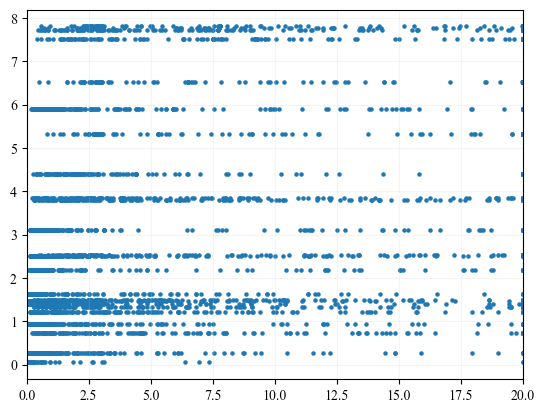

In [133]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

plt.scatter(
    real_evaluations["cut_off_time"],
    real_evaluations["instance_id"].map(ID_TO_CUT_OFF),
    s=5
)

In [142]:
((real_evaluations["cut_off_time"] / real_evaluations["instance_id"].map(ID_TO_CUT_OFF)) < 1).value_counts(normalize=True)

False    0.639388
True     0.360612
dtype: float64

(0.0, 5.0)

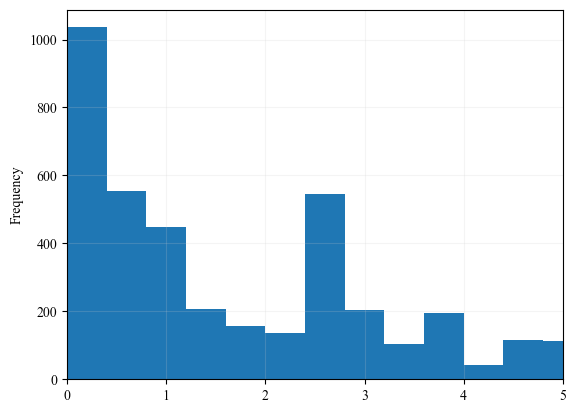

In [138]:
(real_evaluations["cut_off_time"] / real_evaluations["instance_id"].map(ID_TO_CUT_OFF)).plot.hist(bins=1000)
plt.xlim(0, 5)